# `cmip6_preprocessing` Tutorial for Ocean Hack Week 2021

## What is CMIP6?

The Climate Model Intercomparison Project - Phase 6 [CMIP6](https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6) is a globally coordinated effort to run many climate models under identical protocols (e.g. certain emission scenarios). The output of all of these models are however very large. The size of all this output renders the 'download-and-analyze' model, which many of us use pretty inefficient. The solution to this problem is to use data stored in the cloud.
But even with the data accessible almost instantly, analysis is still not as easy as one would want. 

Entering `cmip6_preprocessing` a python package that aims to make CMIP data fully analysis ready by fixing issues in a centralized, community driven code base (as opposed to tons of `if/else` statements in your notebook).

In this tutorial you will learn how to work with CMIP6 data in the cloud.
This includes:
- Finding and selecting data
- Loading the data
- Combining different datasets
- Masking out ocean basins
- Removing model drift
    
All of these assume a basic knowledge of python and xarray.

## Where do I find the data?

The official CMIP6 archive is maintained by [ESGF](https://esgf-node.llnl.gov/projects/cmip6/), but downloadind data from there can be a time and storage consuming task. The pangeo Project has mirrored a substantial part of the archive to the [cloud](https://pangeo-data.github.io/pangeo-cmip6-cloud/) (not all of them though, so if you are missing something always check on the ESGF site first).

So now that you know where the data is located (we are going to use the data on Google Cloud, since this is where our computations will happen). 

All the CMIP6 variables follow a stric vocabulary, so you might want to check out this handy [spreadsheet by Naomi Henderson](https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271). 

### **Working on Climatological Variations**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from dask.diagnostics import ProgressBar

In [5]:
# use intake-esm to load the Pangeo CMIP6 cloud collection
import intake
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

# # I added a convenience function to cmip6_preprocessing.utils which achieves the same thing
# from cmip6_preprocessing.utils import google_cmip_col
# col = google_cmip_col()
# The collection is based on a pandas dataframe:

In [4]:
col.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hfls,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,zg,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
511420,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,Amon,sfcWind,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511421,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,Amon,uas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511422,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,day,rlut,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511423,ScenarioMIP,AS-RCEC,TaiESM1,ssp585,r1i1p1f1,day,tasmin,gn,gs://cmip6/CMIP6/ScenarioMIP/AS-RCEC/TaiESM1/s...,NaN,20210721


The column names represent another set of 'vocabulary' that is useful to learn. Especially the values of `source_id` (the model), `experiment_id` the experiment that was run, and `table_id`(time frequency of output) will appear again and again.
We could just find the dataset we want to analyze and [manually load it with xarray](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html#opening-a-single-zarr-data-store), but that is cumbersome.

Instead we are using the abilities of the `col` object, powered by [intake-esm](https://intake-esm.readthedocs.io/en/latest/) to narrow down our search critera and load the data.

In [7]:
np.sort(col.df["source_id"].unique())

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR',
       'BCC-CSM2-HR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0',
       'CAS-ESM2-0', 'CESM1-1-CAM5-CMIP5', 'CESM1-WACCM-SC', 'CESM2',
       'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM',
       'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CMCC-CM2-VHR4', 'CMCC-ESM2',
       'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5',
       'CanESM5-CanOE', 'E3SM-1-0', 'E3SM-1-1', 'E3SM-1-1-ECA',
       'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-LR',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'EC-Earth3P', 'EC-Earth3P-HR',
       'EC-Earth3P-VHR', 'ECMWF-IFS-HR', 'ECMWF-IFS-LR', 'FGOALS-f3-H',
       'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-AM4', 'GFDL-CM4',
       'GFDL-CM4C192', 'GFDL-ESM2M', 'GFDL-ESM4', 'GFDL-OM4p5B',
       'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'GISS-E2-2-G',
       'HadGEM3-GC31-HM', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-LM',
       'HadGEM3-GC31-MM', 'IITM-ESM', 'I

In [44]:
# create a subcollection with certain search criteria

models = ['CanESM5-CanOE']
cat = col.search(
    variable_id=['tos'],
    source_id=models,
    experiment_id=['historical'], #[https://view.es-doc.org/?renderMethod=name&project=cmip6&type=cim.2.designing.NumericalExperiment&client=esdoc-url-rewrite&name=ssp585]
    grid_label='gn',
    table_id='Omon',
    member_id = ['r2i1p1f1', 'r3i1p1f1', 'r2i1p2f1', 'r3i1p2f1'] 
)

# load all datasets into a python dictionary
ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, 
    storage_options={'token': 'anon'}, 
    aggregate=False,
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [45]:
ddict.keys()

dict_keys(['CMIP.CCCma.CanESM5-CanOE.historical.r3i1p2f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r3i1p2f1/Omon/tos/gn/v20190429/.nan.20190429', 'CMIP.CCCma.CanESM5-CanOE.historical.r2i1p2f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r2i1p2f1/Omon/tos/gn/v20190429/.nan.20190429'])

In [46]:
from cmip6_preprocessing.preprocessing import combined_preprocessing

In [47]:
# load all datasets into a python dictionary
ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False,
    preprocess=combined_preprocessing, # this applies the preprocessing to all datasets
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


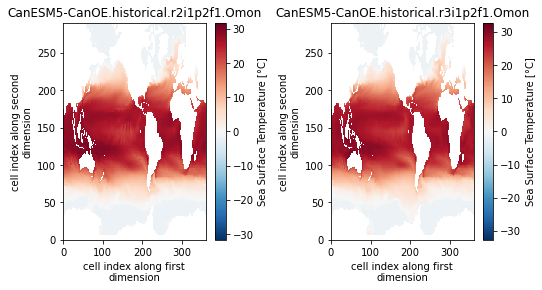

In [57]:
# quick example of how to loop over several models
from cmip6_preprocessing.utils import cmip6_dataset_id
fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=[8,4])
for ax, (name, ds) in zip(axarr.flat, ddict.items()):
    # select the first time step
    ds = ds.isel(time=0)
    # select the datavariable
    da = ds[ds.variable_id]
    # plot
    
    da.plot(ax=ax)
    ax.set_title('.'.join(cmip6_dataset_id(ds).split('.')[2:6]))
    
fig.subplots_adjust(hspace=0.5, wspace=0.5)

#### **Masking ocean basins**

In [65]:
import regionmask
from cmip6_preprocessing.regionmask import merged_mask
# load ocean basin data
basins = regionmask.defined_regions.natural_earth.ocean_basins_50

In [67]:
basins[5]

Region: INDIAN OCEAN (INDIAN OCEAN / 5)
center: [ 82.3165232  -33.85611164]

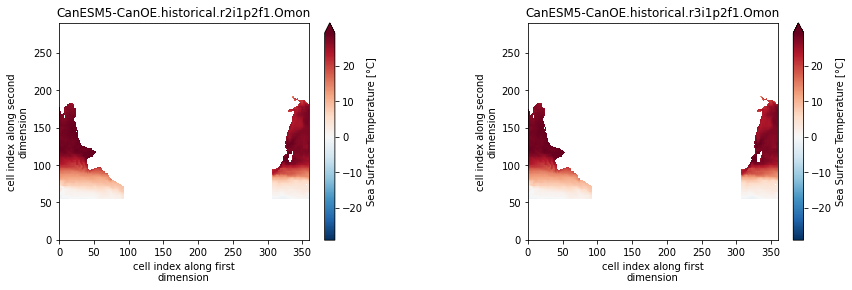

In [76]:
fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=[14,4])
for ax, (name, ds) in zip(axarr.flat, ddict.items()):
    # show just the first time step
    ds = ds.isel(time=0)
    
        # average all members
    if 'member_id' in da.dims:
        da = ds.mean('member_id')
        
    # mask out the indian ocean
    mask = merged_mask(basins, da)
    
    da_masked = da.where(mask == 5) # switch the number here for a different basin.
    
    da_masked.plot(ax=ax, robust=True)
    ax.set_title('.'.join(cmip6_dataset_id(ds).split('.')[2:6]))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

#### **Aggregate the masked data to a time series**

[########################################] | 100% Completed |  6.6s


ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

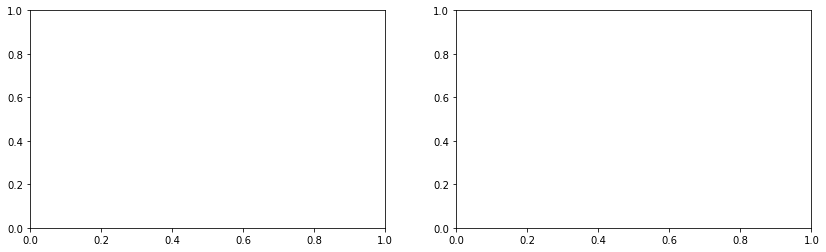

In [79]:
time_window = 36 # for monthly data here this is a 3 year window

fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=[14,4])
for ax, (name, ds) in zip(axarr.flat, ddict.items()):
    # show just the first time step
        
    # mask out the indian ocean
    mask = merged_mask(basins, ds)
    
    ds_masked = ds.where(mask == 5) # switch the number here for a different basin.
    
    ds_timeseries = ds_masked.mean(['x', 'y'])
    # this is now a heavy computation, using the full dataset!
    with ProgressBar():
        ds_timeseries = ds_timeseries.load()
    
    ds_timeseries = ds_timeseries.coarsen(time=time_window, boundary='trim').mean() # average in 3 year intervals to supress short term variability
   
    ds_timeseries.plot(ax=ax, hue='member_id', color='C0', add_legend=False)
    ax.set_title('.'.join(cmip6_dataset_id(ds).split('.')[2:6]))
fig.subplots_adjust(hspace=0.5, wspace=0.5)